In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
raw_data = pd.read_csv('/content/drive/MyDrive/Google Colab Notebooks/Mini Sem 8/dataset/large sample/IBM_2years_60Min.csv')

In [3]:
print(raw_data.shape)
raw_data.head()

(6707, 7)


,Unnamed: 0,time,open,high,low,close,volume
0,0,2020-04-27 05:00:00,108.325771,108.325771,108.325771,108.325771,344
1,1,2020-04-27 08:00:00,108.153113,108.714252,108.153113,108.714252,2625
2,2,2020-04-27 09:00:00,108.774682,109.525746,108.774682,109.033670,8240
3,3,2020-04-27 10:00:00,108.774682,109.577543,108.317138,109.180429,760734
4,4,2020-04-27 11:00:00,109.189062,109.504163,108.627923,109.094791,595594


In [4]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

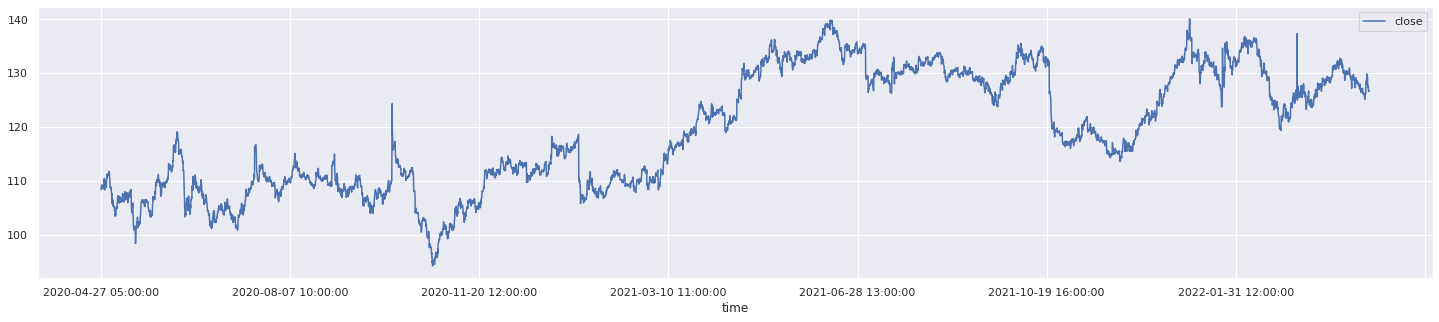

In [5]:
close_ds.plot(x='time', y='close', figsize=(25, 5))

In [6]:
# ema and vwap

from time import time
from datetime import datetime

"""
  Parameters
    d - previous number of data points to use for EMA
    price - stock price list
  Returns
    list of EMA of all points starting from the dth data point
"""
def calculate_ema(d, price) :
  print(f" Days {d} \n Length of prices {len(price)}")
  # formula https://www.investopedia.com/terms/e/ema.asp
  ema = []                                    # stores the ema starting from the dth data point i.e corresponding to price[d]
  ema_yesterday = sum(price[:d])/d            # sma of first d days, this will serve as the EMA of yesterday
  multiplier = 2/(d+1)                        # multiplier 
  for i in range(d,len(price)):
    ema_today = price[i]*multiplier + ema_yesterday*(1-multiplier)  
    ema.append(ema_today)
    ema_yesterday = ema_today
  print(f" Length of EMA list {len(ema)}")
  return ema



"""
  Parameters
    df - original dataframe
  Returns
    list of vwap
"""

def calculate_vwap(df):
  
  time_format = "%Y-%m-%d %H:%M:%S"
  
  sum_pv = 0
  sum_volume = 0
  
  vwap = []
  
  previous_day = datetime.strptime(df["time"][0], time_format).day

  for i in range(len(df)):
    
    current_day = datetime.strptime(df["time"][i], time_format).day

    if(current_day!=previous_day):
      sum_pv = 0
      sum_volume = 0

    previous_day = current_day

    sum_pv += ((df["high"][i] + df["low"][i] + df["close"][i])/3) * df["volume"][i]
    sum_volume += df["volume"][i]
    vwap.append(sum_pv/sum_volume)
  return vwap

In [7]:
# price list
price = list(close_ds.drop('time', axis=1).values)
print(f"len prices = {len(price)}")

# ema taking 10 previous points for calculation
ema = calculate_ema(10,price)
print(f"len ema = {len(ema)}")

vwap = calculate_vwap(raw_data)
print(f"len vwap = {len(vwap)}")

len prices = 6707
 Days 10 
 Length of prices 6707
 Length of EMA list 6697
len ema = 6697
len vwap = 6707


In [8]:
# make all ema, vwap, prices lists of equal length 
price = price[-len(ema):]
vwap = vwap[-len(ema):]

No handles with labels found to put in legend.


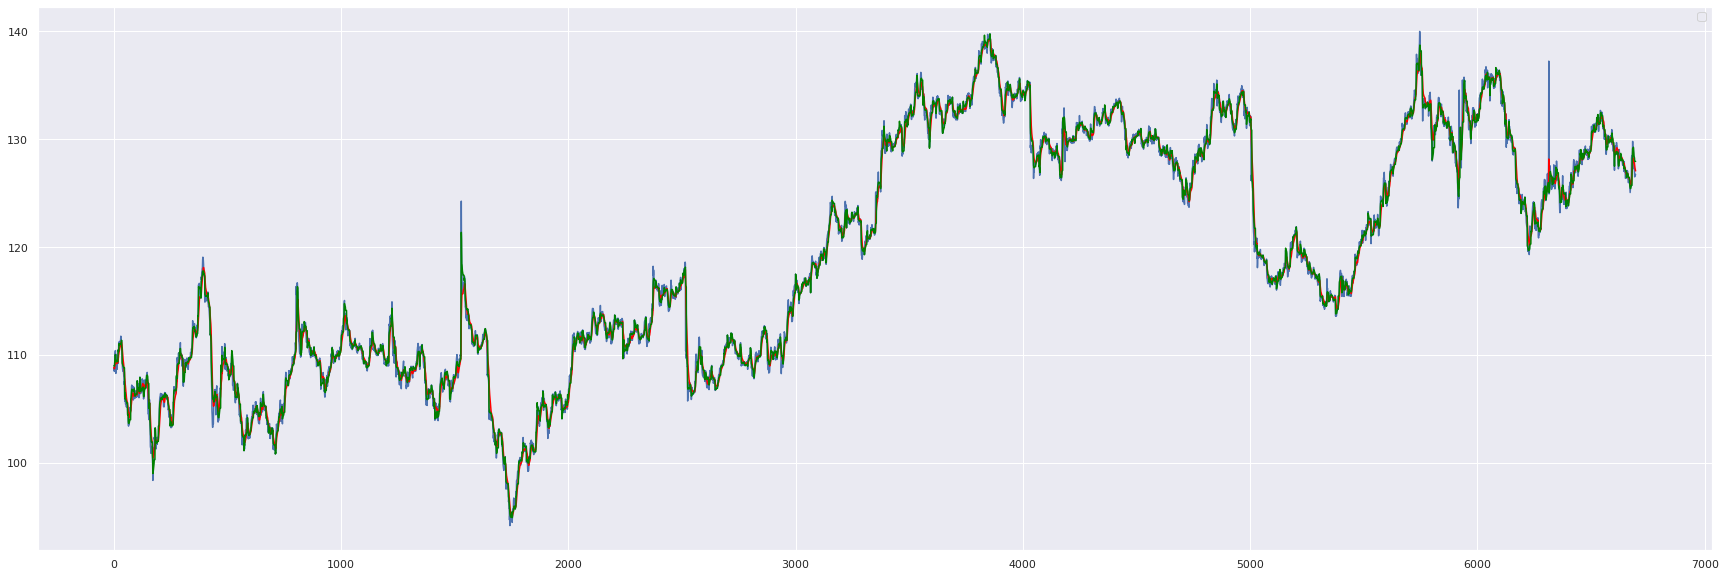

In [9]:
plt.figure(figsize=(30,10))

plt.plot(price)
plt.plot(ema, color='red')
plt.plot(vwap,color='green')
plt.legend()
plt.show()

In [10]:

# split a multivariate sequence into samples
# n_steps ---> number of lag observations

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:

ema = np.array(ema).reshape(len(ema), 1)
vwap = np.array(vwap).reshape(len(vwap), 1)
price = np.array(price).reshape(len(price), 1)
dataset = np.hstack((ema, vwap, price))
print(dataset)

[[108.8445086  108.98114654 108.61065716]
 [108.83181294 108.98111822 108.77468248]
 [108.77433698 108.98087767 108.51569514]
 ...
 [127.2337918  127.9427036  126.66      ]
 [127.14582966 127.94212141 126.75      ]
 [127.06476972 127.94199548 126.7       ]]


In [12]:
n_steps = 3 
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
print(X[0], y[0])

(6695, 3, 3) (6695,)
[[108.8445086  108.98114654 108.61065716]
 [108.83181294 108.98111822 108.77468248]
 [108.77433698 108.98087767 108.51569514]] 108.515695138


In [13]:
# train_test_split 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# type(X_train.values)

(4686, 3, 3)
(4686,)
(2009, 3, 3)
(2009,)


In [14]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

# CNN

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             448       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,749
Trainable params: 3,749
Non-trainable params: 0
______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
cnn_history = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, verbose=2)

Epoch 1/40
147/147 - 10s - loss: 1395.2764 - val_loss: 0.5945 - 10s/epoch - 71ms/step
Epoch 2/40
147/147 - 1s - loss: 0.4796 - val_loss: 0.5738 - 596ms/epoch - 4ms/step
Epoch 3/40
147/147 - 1s - loss: 0.4776 - val_loss: 0.5715 - 609ms/epoch - 4ms/step
Epoch 4/40
147/147 - 1s - loss: 0.4762 - val_loss: 0.5701 - 622ms/epoch - 4ms/step
Epoch 5/40
147/147 - 1s - loss: 0.4758 - val_loss: 0.5721 - 600ms/epoch - 4ms/step
Epoch 6/40
147/147 - 1s - loss: 0.4747 - val_loss: 0.5723 - 623ms/epoch - 4ms/step
Epoch 7/40
147/147 - 1s - loss: 0.4750 - val_loss: 0.5687 - 776ms/epoch - 5ms/step
Epoch 8/40
147/147 - 1s - loss: 0.4741 - val_loss: 0.5680 - 614ms/epoch - 4ms/step
Epoch 9/40
147/147 - 1s - loss: 0.4745 - val_loss: 0.5695 - 626ms/epoch - 4ms/step
Epoch 10/40
147/147 - 1s - loss: 0.4741 - val_loss: 0.5672 - 619ms/epoch - 4ms/step
Epoch 11/40
147/147 - 1s - loss: 0.4730 - val_loss: 0.5665 - 618ms/epoch - 4ms/step
Epoch 12/40
147/147 - 1s - loss: 0.4729 - val_loss: 0.5687 - 613ms/epoch - 4ms/ste

Text(0, 0.5, 'MSE')

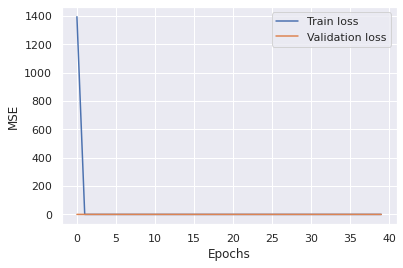

In [16]:
# plots 
fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [17]:
# RMSE calculation
from sklearn.metrics import mean_squared_error
cnn_train_pred = model_cnn.predict(X_train)
cnn_test_pred = model_cnn.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, cnn_test_pred)))

Train rmse: 0.6519280375936559
Validation rmse: 0.7162019773445567


In [18]:
print(y_test[0:10])
print(cnn_test_pred[0:10])

[126.87089947 126.73113276 127.0013484  126.10684147 126.20933706
 126.41432823 126.36773932 126.20933706 126.41432823 126.00434588]
[[127.0867  ]
 [126.99951 ]
 [126.88026 ]
 [126.76469 ]
 [126.52822 ]
 [126.34825 ]
 [126.31272 ]
 [126.28415 ]
 [126.269226]
 [126.24288 ]]


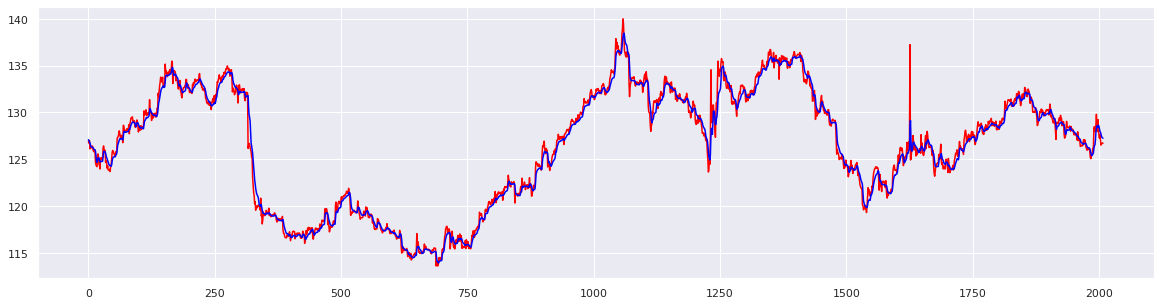

In [19]:
# pd.Series(y_test[:100]).plot(figsize=(30, 10))
# pd.Series(cnn_test_pred.flatten()[:100]).plot(figure=(30, 10))
plt.figure(figsize=(20, 5))
plt.plot(pd.Series(y_test), color='red')
plt.plot(pd.Series(cnn_test_pred.flatten()), color='blue')

In [20]:
# MAPE calculation
from sklearn.metrics import mean_absolute_percentage_error
print('Train MAPE:', mean_absolute_percentage_error(y_train, cnn_train_pred))
print('Validation MAPE:', mean_absolute_percentage_error(y_test, cnn_test_pred))

Train MAPE: 0.003935010218998063
Validation MAPE: 0.0038593333718255117


In [31]:
X_test[0][n_steps-1][no_of_features-1]

126.870899472

In [33]:
# classification accuracy 

# y_test_flattened = y_test.values.flatten()
cnn_test_pred_flattened = cnn_test_pred.flatten()
total_number_of_samples = len(y_test)
no_of_features = X_test.shape[2]
no_of_correct_predictions = 0
for i in range(0, total_number_of_samples):
    prev_value = X_test[i][n_steps-1][no_of_features-1]
    actual_value = y_test[i]
    predicted_value = cnn_test_pred_flattened[i]
    print(f'i = {i}, prev_val = {prev_value}, actual = {actual_value}, pred = {predicted_value}')
    if ((prev_value > actual_value and prev_value > predicted_value) or (prev_value < actual_value and prev_value < predicted_value)):
        no_of_correct_predictions += 1

print(f'Accuracy of correct trend prediction = {no_of_correct_predictions / total_number_of_samples}');


i = 0, prev_val = 126.870899472, actual = 126.870899472, pred = 127.08670043945312
i = 1, prev_val = 126.731132764, actual = 126.731132764, pred = 126.99951171875
i = 2, prev_val = 127.001348399, actual = 127.001348399, pred = 126.88025665283203
i = 3, prev_val = 126.10684147, actual = 126.10684147, pred = 126.76468658447266
i = 4, prev_val = 126.209337055, actual = 126.209337055, pred = 126.5282211303711
i = 5, prev_val = 126.414328227, actual = 126.414328227, pred = 126.34825134277344
i = 6, prev_val = 126.367739324, actual = 126.367739324, pred = 126.3127212524414
i = 7, prev_val = 126.209337055, actual = 126.209337055, pred = 126.28414916992188
i = 8, prev_val = 126.414328227, actual = 126.414328227, pred = 126.26922607421875
i = 9, prev_val = 126.004345884, actual = 126.004345884, pred = 126.24288177490234
i = 10, prev_val = 125.873896957, actual = 125.873896957, pred = 126.15707397460938
i = 11, prev_val = 125.808672493, actual = 125.808672493, pred = 126.064697265625
i = 12, pre